This is the beginning of the Delaunay and clustering. I also coded the way to rotate and then unrotate the hull within this.

#

This is to make the CI using a threshold. The first section is just setting up PyVBMC and then the second section is creating the CI.

In [129]:
import pandas as pd  # Data handling
import matplotlib.pyplot as plt # visualization
from scipy.integrate import odeint # numerical integration
import numpy as np
from pyvbmc import VBMC # VMBC object
import scipy.stats as scs # scipy stats to get distributions from
from pyvbmc.priors import UniformBox, Trapezoidal, SplineTrapezoidal, SmoothBox # nice priors from PyVBMC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# import scipy.stats as scs
import scipy.integrate as integrate
from shapely.geometry import Point # used within the ConcaveHull object and to get points out of the hull
from shapely.geometry import LineString # used within the ConcaveHull object
from shapely.geometry import Polygon # used within the ConcaveHull object and to make the polygon to get the points out of the hull

import random # to get points out of the hull

# from matplotlib.path import Path # unsure if this is needed
from numpy import asarray, concatenate, ones
import matplotlib.patches as patches # to make the polygon


import matplotlib.path as mplPath
import time

from scipy.spatial import Delaunay

# PyVBMC SETUP

First, let's set up a PyVBMC optimize routine for our original differential equation:

$$\ddot{x} = -x - ax^b$$

which we now generalize to be able to use all values of b:

$$\ddot{x} = -x - sign(x)a|x|^b$$

$0 \leq a\leq0.5$

 $1\leq b \leq 5$

In [54]:
def diffyqs(X, t, a, b):
    xdot,x = X
    dx = xdot
    dv = -x - np.sign(x) * a * np.abs(x)**b
    return [dv, dx]



initial_condition = [0.0, 3.5]
t = np.arange(0,10,0.05)

a = 0.5
b = 1.44
sol = odeint(diffyqs, initial_condition, t, args=(a,b))
true_a_b = [a,b]
x_true = sol[:,1]

a_min, a_max, b_min, b_max = 0.0, 0.7, 1.0, 5.0

However, I want to add some noise to it, to make sure that our threshold is reasonable. This step can be ignored completely if one doesn't want noise, just uncomment out *x_true* in the above code block.

In [4]:
# y = sol[:, 1]
# changed = y + np.random.normal(0, .25, len(y))
# sol2 = np.ndarray((len(y),2))
# for i in range(len(y)):
#     sol2[i, 0] = sol[i, 0]
#     sol2[i, 1] = changed[i]
#     if i == 0:
#         sol2[i, 0] = sol[i, 0]
#         sol2[i, 1] = 3.5

# x_true = sol2[:,1]

Now we can plot it to see how it works:

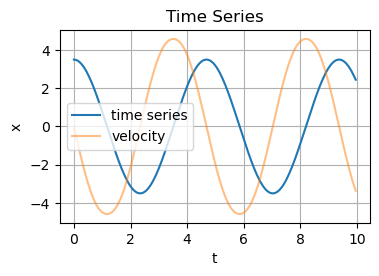

In [55]:
def plot_ts(t,ts,v, mode = 0):
    plt.figure(figsize=(4,2.5))
    if mode == 0:
        plt.plot(t,ts)
        plt.title('Time Series')
        plt.xlabel('t')
        plt.ylabel('x')
        plt.grid()
        plt.show()
    else:
        plt.plot(t,ts, label = 'time series')
        plt.plot(t,v, label = 'velocity', alpha = 0.5)
        plt.title('Time Series')
        plt.xlabel('t')
        plt.ylabel('x')
        plt.legend()
        plt.grid()
        plt.show()

# plot_ts(t,sol2[:, 1],sol2[:, 0],1)
plot_ts(t,sol[:, 1],sol[:, 0],1)

Next we create our log_likelihood. In this case I have noise, so the sigma is included, but without noise the other return function can simply be used instead

In [56]:
def log_likelihood(theta):
    a,b = theta

    sol = odeint(diffyqs, initial_condition, t, args=(a,b)) # get solution of ODE with current choice of params
    sigma = .1
    # return -np.sum((sol[:,1] - x_true)**2) # normal distribution sorta
    return np.sum(np.log(1/(sigma* (2*np.pi)**0.5)) - (0.5/sigma**2) * (sol[:,1] - x_true)**2)

We can begin setting up the lower and upper bounds and the prior for VBMC

In [57]:
D = 2  # 2-D since there are 2 params we're estimating

LB = np.full((1, D), a_min)  # Lower bounds
LB[0][1] = b_min
UB = np.full((1, D), a_max)  # Upper bounds
UB[0][1] = b_max

PLB = np.copy(LB) + 0.05
PUB = np.copy(UB) - 0.05

# x0 = np.full((1, D), 0.45) # starting point for inference   # 1.5 * np.ones((1, D))
# x0[0][1] = 4.5

x0_rand = np.random.uniform(PLB, PUB)


prior1 = SplineTrapezoidal(LB, PLB, PUB, UB)

options1 = {
    "display": "off"
}


Next is initializing the VBMC object and doing the optimizing

In [58]:
vbmc = VBMC(log_likelihood, x0_rand, LB, UB, PLB, PUB, prior = prior1, options = options1) # initialize VMBC object
vp, results = vbmc.optimize() # do optimization (might take a while)

Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: 268.670 +/-0.005.
Caution: Returned variational solution may have not converged.


We plot it below to check that nothing went insanely wrong:

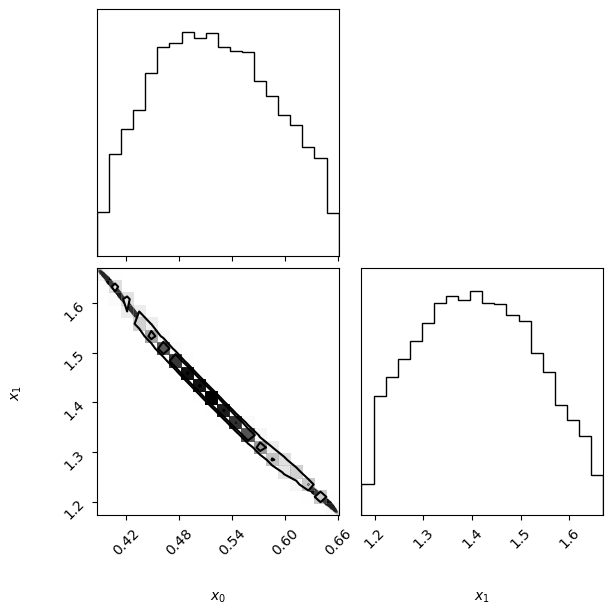

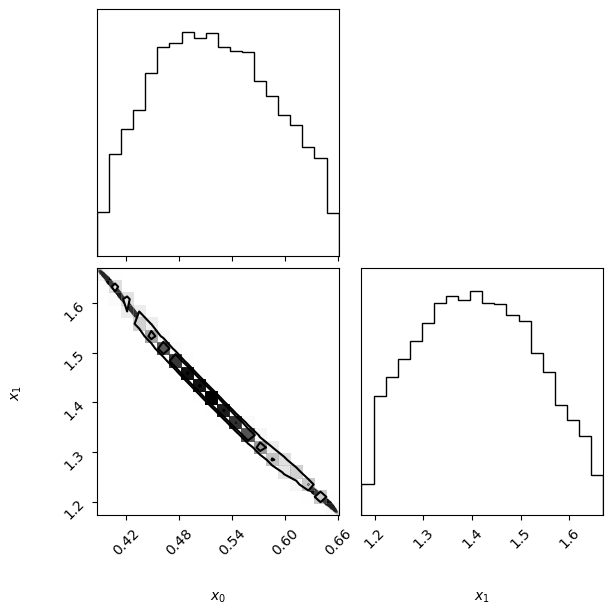

In [60]:
vp.plot()

# CREATING CI WITH THRESHOLD

Now we want to find samples that have a pdf equal to or larger than the pdf of the true value.

In [414]:
def samples_above_threshold(vp, true_value, n_samples): # change to a while loop
    if len(true_value) > 1:
        threshold = min(vp.pdf(np.array(true_value)))
    else:
        threshold = vp.pdf(true_value)

    # threshold = vp.pdf(true_value) # find the pdf of our true value
    threshold_edited = threshold*.75
    Xs, _ = vp.sample(n_samples * 5) # get samples out of the distribution
    pdfs = vp.pdf(Xs) # find the pdf of each of those samples
    # pdfs_copy = np.copy(pdfs.tolist())    

    high_threshold_samples = []
    # # count = 0

    # threshold_samples_1 = pdfs[pdfs >= threshold_edited]

    # while len(high_threshold_samples) < n_samples:
    #     # high_threshold_samples = pdfs[pdfs >= threshold_edited]
    #     trying = pdfs_copy.pop()
    #     if trying >= threshold_edited:
    #         high_threshold_samples
    
    #     if pdfs[i] >= threshold_edited:
    #         high_threshold_samples.append(Xs[i])

    # for i in range(len(pdfs)): # if the pdf is larger than the threshold, the point gets added to high_threshold_samples
    #     count += 1
    #     if pdfs[i] >= threshold_edited:
    #         high_threshold_samples.append(Xs[i])
    #     # if count == 2000:
    #     #     return np.array(high_threshold_samples)

    # count = 0
    # for i in range(len(pdfs)):
    #     print(i, count)
    #     while len(high_threshold_samples) < n_samples:
    #         count += 1
    #         if pdfs[i] >= threshold_edited:
    #             high_threshold_samples.append(Xs[i])
    #         if count == len(pdfs):
    #             Xs, _ = vp.sample(n_samples)
    #             pdfs = vp.pdf(Xs)
    #             print('hit')
    #             break

    # count = 0
    # while len(high_threshold_samples) < n_samples:
    #     count = 0
    for i in range(len(pdfs)):
        if pdfs[i] >= threshold_edited and len(high_threshold_samples) <= n_samples:
            high_threshold_samples.append(Xs[i])
            if len(high_threshold_samples) == n_samples:
                break

    # if len(high_threshold_samples) < n_samples:
    #     Xs, _ = vp.sample(n_samples)
    #     pdfs = vp.pdf(Xs)



    return np.array(high_threshold_samples)

In [415]:
Xss, _ = vp.sample(int(5e5)) # get samples out of the distribution
pdfss = vp.pdf(Xss) # find the pdf of each of those samples
print(pdfss)
# print(len(pd))

[[1063.82750598]
 [ 438.08582838]
 [ 875.25258792]
 ...
 [1049.84709178]
 [ 727.06043059]
 [ 669.12139751]]


In [416]:
samp = samples_above_threshold(vp, true_a_b, int(5e5))

print(len(samp))
print(vp.pdf(true_a_b))
# np.argmax(samp)

500000
[1270.08002943]


In [373]:
vp.stats
vp.sigma
vp.log_pdf
# vp.log_pdf.stats
# vp.log_pdf(true_a_b)
vp.mtv

<bound method VariationalPosterior.mtv of VariationalPosterior:
    self.D = 2,
    self.K = 50,
    self.mu = (2, 50) ndarray,
    self.w = (1, 50) ndarray,
    self.sigma = (1, 50) ndarray,
    self.lambd = 
        [[0.7204],
         [1.217 ]] : ndarray,
    self.stats = <dict object at 0x176438040>,
    self._mode = None,
    self.bounds = None,
    self.eta = (1, 50) ndarray,
    self.optimize_lambd = True,
    self.optimize_mu = True,
    self.optimize_sigma = True,
    self.optimize_weights = True,
    self.parameter_transformer = ParameterTransformer:
        self.lb_orig = [[0., 1.]] : ndarray,
        self.ub_orig = [[0.7, 5. ]] : ndarray,
        self.type = [12., 12.] : ndarray,
        self.mu = [0., 0.] : ndarray,
        self.delta = [1., 1.] : ndarray,
        self.scale = [0.189 , 0.0071] : ndarray,
        self.R_mat = 
            [[ 0.9501,  0.3121],
             [-0.3121,  0.9501]] : ndarray,
        self._bounded_transforms = <dict object at 0x1763b1180>,
       

[1270.08002943]


0

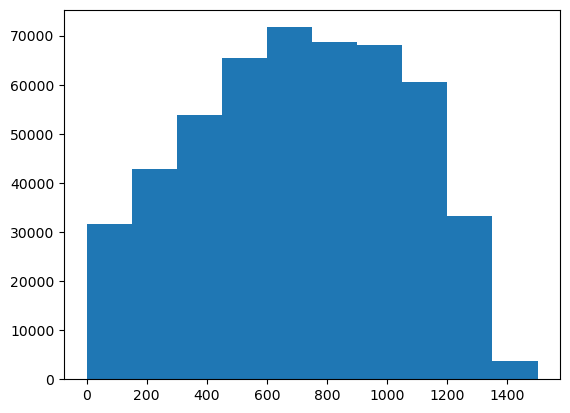

In [379]:
samples_try, _ = vp.sample(int(5e5))
threshold_try = vp.pdf(samples_try)
print(vp.pdf(true_a_b))
plt.hist(threshold_try)
scs.describe(threshold_try)
scs.skewtest(threshold_try)
scs.mstats.zscore(threshold_try)
np.argmax(vp)

In [355]:
threshold_samples = samples_above_threshold(vp, true_a_b, int(5e5))
print(len(threshold_samples))
print(vp.pdf(true_a_b))

140788
[1270.08002943]


-1.833172046386706 2.3584924123993996
1.4785698301337806
[1014.76860948]
[0.05189831]


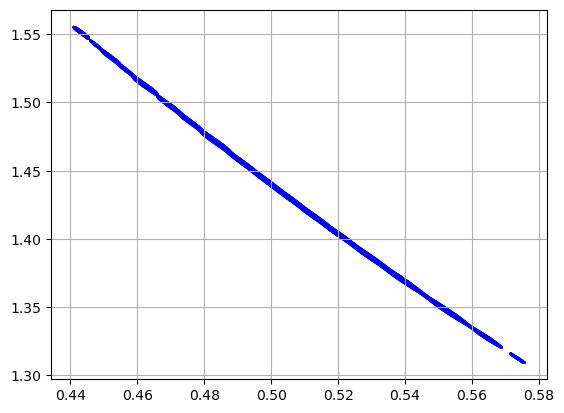

In [357]:
plt.scatter(threshold_samples[:,0], threshold_samples[:,1], color = 'b', s=.1)

# m, n = np.polyfit(np.ndarray.flatten(xy[:,0]), np.ndarray.flatten(xy[:,1]), 1)
m, n = np.polyfit(np.array(threshold_samples[:,0]), np.array(threshold_samples[:,1]), 1)
new_y = m * threshold_samples[:,0] + n
angle = np.arctan(m)
print(m,n)
plt.grid()
# plt.plot(np.ndarray.flatten(threshold_samples[:,0]), np.ndarray.flatten(new_y), color = 'black')

# print(m*(0.51)+n)
print(m*(0.48)+n)
# print(vp.pdf([0.51,1.4223728673941778]))
print(vp.pdf([0.48,1.478240377208035]))
print(vp.pdf([0.48,1.47]))
# plt.scatter(min(xy[:,0]), min(new_y), color='red')
# # plt.scatter(max(xy[:,0]), max(new_y), color='red')
# midpoint = [(min(xy[:,0])+ max(xy[:,1]))/2, (min(new_y) + max(new_y))/2]
# print(midpoint)

check with a bimodal; make sure that lowering the threshold doesn't change the bimodality

Make a lower bound to the true threshold
- can renormalize at the very end (when "changing" what the pdf is of certain points)
- can just use the original pdfs
- if all the 

<!-- can use the centroid -->

<!-- moving least squares interpolation; c infinity surface -->


We begin the Delaunay triangulation. I'll try with voronoi next.

(1.42, 1.46)

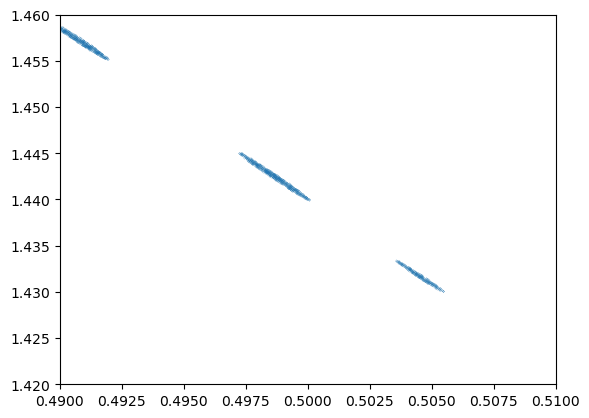

In [156]:
points = threshold_samples
plt.scatter(points[:,0], points[:,1], s=.01)
plt.xlim(.49,.51)
plt.ylim(1.42, 1.46)

[[0.52083702 1.40201721]
 [0.48205158 1.47407679]
 [0.52949133 1.38686898]
 ...
 [0.48483973 1.46935238]
 [0.53872063 1.37093634]
 [0.52874827 1.38798647]]


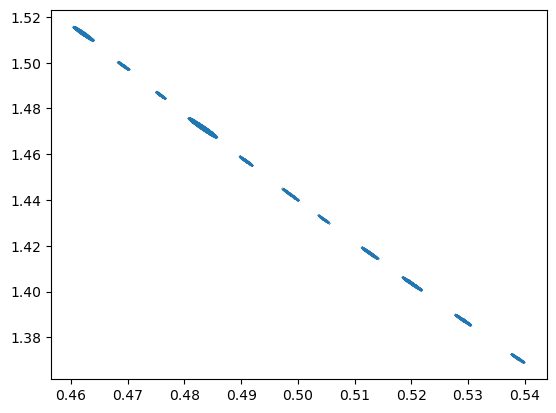

In [154]:
points = threshold_samples
plt.scatter(points[:,0], points[:,1], s=.01)
print(points)
tri = Delaunay(points)

plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o', lw=.1)
# plt.xlim(.41,.415)
# plt.ylim(1.60, 1.65)
plt.show()

In [163]:
def minkowskiDist(v1, v2):
    #Assumes v1 and v2 are equal length arrays of numbers
    dist = 0
    for i in range(len(v1)):
        dist += abs(v1[i] - v2[i])**2
    return dist**(1/2)

In [ ]:
class create_CI_delaunay(): # i never finished making the class
    def __init__(self, vp, true_value, n_samples, dimensions):
        self.vp = vp
        self.true_value = true_value
        self.n_samples = int(n_samples)
        self.dimensionality = int(dimensions)

    def samples_above_threshold(self):
        vp = self.vp
        true_value = self.true_value
        n_samples = self.n_samples

        threshold = vp.pdf(true_value) # find the pdf of our true value
        Xs, _ = vp.sample(n_samples) # get samples out of the distribution
        pdfs = vp.pdf(Xs) # find the pdf of each of those samples

        high_threshold_samples = []
        count = 0
        for i in range(len(pdfs)): # if the pdf is larger than the threshold, the point gets added to high_threshold_samples
            count += 1
            if pdfs[i] >= threshold:
                high_threshold_samples.append(Xs[i])
            # if count == 2000:
            #     return np.array(high_threshold_samples)

        return np.array(high_threshold_samples)


    # def cluster_samples(self):
        
    

In [207]:
class Example(object):
    
    def __init__(self, features):
        #Assumes features is an array of floats
        # self.name = name
        self.features = features
        # self.label = label
        # self.featureNames = featureNames

    def dimensionality(self):
        return len(self.features)
    
    # def getFeatureNames(self):
    #     return self.featureNames


    def getFeatures(self):
        # print(self.features[:])
        return self.features[:]
    
    # def getLabel(self):
    #     return self.label
    
    # def getName(self):
    #     return self.name
    
    def distance(self, other):
        return minkowskiDist(self.features, other.getFeatures())


In [180]:
def getData2Features(pointy):
    #read in data
    pts = pointy
    # print(df) ###
    points = []
    for i in range(len(pts)):
        features=np.array([pts[i][0],pts[i][1]])
        # print(features)
        points.append(Example(features))
    return points

In [208]:
try1 = getData2Features(threshold_samples)

In [177]:
# example_ = Example(threshold_samples)

In [215]:
class Cluster(object):
    
    def __init__(self, examples):
        """Assumes examples a non-empty list of Examples"""
        self.examples = examples
        self.centroid = self.computeCentroid()
        
    def update(self, examples):
        """Assume examples is a non-empty list of Examples
           Replace examples; return amount centroid has changed"""
        oldCentroid = self.centroid
        self.examples = examples
        self.centroid = self.computeCentroid()
        return oldCentroid.distance(self.centroid)
    
    def computeCentroid(self):
        vals = np.array([0.0]*self.examples[0].dimensionality())
        for e in self.examples: #compute mean
            vals += e.getFeatures()
        # centroid = Example('centroid', vals/
        #     len(self.examples),self.examples[0].getFeatureNames())
        centroid = Example(vals/ len(self.examples))
        return centroid

    def getCentroid(self):
        return self.centroid

    def inertia(self):
        totDist = 0
        for e in self.examples:
            totDist += (e.distance(self.centroid))**2
        return totDist
        
    def members(self):
        for e in self.examples:
            yield e

    # def __str__(self):
    #     names = []
    #     for e in self.examples:
    #         names.append(e.getName())
    #     names.sort()
    #     result = ('Cluster with centroid '
    #            + str(self.centroid.getFeatures()) + ' contains:\n  ')
    #     for e in names:
    #         result = result + e + ', '
    #     return result[:-2] #remove trailing comma and space    

In [183]:
def kmeans(examples, k, verbose = False):
    #Get k randomly chosen initial centroids, create cluster for each
    initialCentroids = random.sample(examples, k)
    clusters = []
    for e in initialCentroids:
        clusters.append(Cluster([e]))
        
    #Iterate until centroids do not change
    converged = False
    numIterations = 0
    while not converged:
        numIterations += 1
        #Create a list containing k distinct empty lists
        newClusters = []
        for i in range(k):
            newClusters.append([])
            
        #Associate each example with closest centroid
        for e in examples:
            #Find the centroid closest to e
            smallestDistance = e.distance(clusters[0].getCentroid())
            index = 0
            for i in range(1, k):
                distance = e.distance(clusters[i].getCentroid())
                if distance < smallestDistance:
                    smallestDistance = distance
                    index = i
            #Add e to the list of examples for appropriate cluster
            newClusters[index].append(e)

        for c in newClusters: #Avoid having empty clusters
            if len(c) == 0:
                raise ValueError('Empty Cluster')
        
        #Update each cluster; check if a centroid has changed
        converged = True
        for i in range(k):
            if clusters[i].update(newClusters[i]) > 0.0:
                converged = False
        #plotClusters(clusters)
        if verbose:
            print('Iteration #' + str(numIterations))
            for c in clusters:
                print(c)
            print('') #add blank line

    return clusters

In [184]:
def trykmeans(examples, numClusters, numTrials, verbose = False):
    """Calls kmeans numTrials times and returns the result with the
          lowest dissimilarity"""
    best = kmeans(examples, numClusters, verbose)
    trial = 1
    while trial < numTrials:
        try:
            clusters = kmeans(examples, numClusters, verbose)
        except ValueError:
            continue #If failed, try again
        if totalInertia(clusters) < totalInertia(best):
            best = clusters
        trial += 1
    return best

In [220]:
def plotClusters(clusters):
    colors = ['r','g','b','m','c']
    i = 0
    for c in clusters:
        col = colors[i % len(colors)]
        i = i + 1
        x_pos =[]
        y_pos = []
        x_neg =[]
        y_neg = []

        #just plot first two features
        for pt in c.members():
            x_pos.append(pt.features[0])
            y_pos.append(pt.features[1])
            # if (pt.getLabel() == 1):
            #     x_pos.append(pt.features[0])
            #     y_pos.append(pt.features[1])
            # else:
                # x_neg.append(pt.features[0])
                # y_neg.append(pt.features[1])
        plt.scatter(x_neg,y_neg,c=col,marker='o',label=f"{i}-live")
        plt.scatter(x_pos,y_pos,c=col,marker='x',label=f"{i}-die")

        plt.scatter([c.getCentroid().features[0]],[[c.getCentroid().features[1]]],c=col,marker='*',s=128)
        plt.text(x=c.getCentroid().features[0]+.1,y=c.getCentroid().features[1]+.05,s=f"Centroid {i}",fontsize=20)
        plt.xlabel(c.getCentroid().getFeatureNames()[0])
        plt.ylabel(c.getCentroid().getFeatureNames()[1])
    plt.legend()
    plt.show()

In [272]:
try_k = trykmeans(try1, 12, 10)

try a case with two actual true answers

In [242]:
# try_k[0].examples
# print(try_k[0].examples[0].getFeatures())
try_k

In [239]:
first_cluster = try_k[0].examples

cluster_1_pts = []
for i in range(len(first_cluster)):
    cluster_1_pts.append(first_cluster[i].getFeatures())
cluster_1_pts = np.array(cluster_1_pts)
print(cluster_1_pts)

[[0.52883746 1.38823377]
 [0.52853064 1.38843188]
 [0.52825516 1.38906747]
 [0.52810001 1.38923364]
 [0.52835352 1.38910919]
 [0.52809327 1.38928204]
 [0.52820485 1.38894825]
 [0.52792272 1.38944152]
 [0.5291771  1.38781296]
 [0.52888946 1.38805124]
 [0.52838095 1.38860342]
 [0.52898299 1.38783411]
 [0.52811324 1.38937912]
 [0.52824606 1.38901481]
 [0.52890196 1.38783304]
 [0.52858253 1.38862974]
 [0.52872917 1.38846148]
 [0.52890573 1.38763843]
 [0.5285895  1.38839028]
 [0.5277335  1.38990591]
 [0.52867419 1.38855873]
 [0.5284257  1.3890025 ]
 [0.52773895 1.38997753]
 [0.52790468 1.3897205 ]
 [0.52833263 1.38908663]
 [0.52877093 1.38828687]
 [0.52862865 1.38817279]
 [0.52800353 1.38951749]
 [0.52822563 1.38898373]
 [0.52814252 1.38905177]
 [0.52829753 1.38877348]
 [0.52842335 1.38869618]
 [0.52842783 1.38884095]
 [0.52851158 1.38872382]
 [0.52904917 1.38803145]
 [0.52793382 1.38970103]
 [0.52876419 1.38852511]
 [0.52888816 1.38805195]
 [0.52779743 1.38976836]
 [0.52826735 1.3891024 ]


In [257]:
def get_cluster_points(try_kmeans):
    try_k = try_kmeans
    all_clusters = []
    for cluster in try_k:
        cluster_pts = []
        examples_cluster = cluster.examples
        for examp in examples_cluster:
            cluster_pts.append(examp.getFeatures())
        all_clusters.append(np.array(cluster_pts))
    return all_clusters



In [273]:
cluster_all = get_cluster_points(try_k)

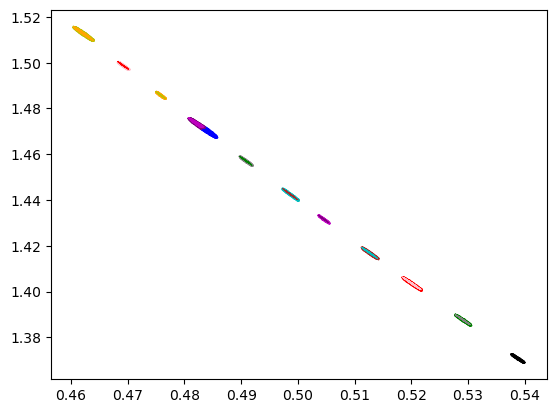

In [ ]:
colors = ['b','g','r','c','m','y','k','orange','purple','brown','pink','gray']

for i in range(len(cluster_all)):
    plt.scatter(cluster_all[i][:,0], cluster_all[i][:,1], color=colors[i], s=.1)
    tri = Delaunay(cluster_all[i])
    plt.triplot(cluster_all[i][:,0], cluster_all[i][:,1], tri.simplices, color= colors[-i], lw=.1)

plt.xlim(.48,.485)
plt.ylim(1.465, 1.48)

check n points (avoid finding good numbers) within the valley
- valley as sequence of points within the valleys

ML to check whether or not there are clusters

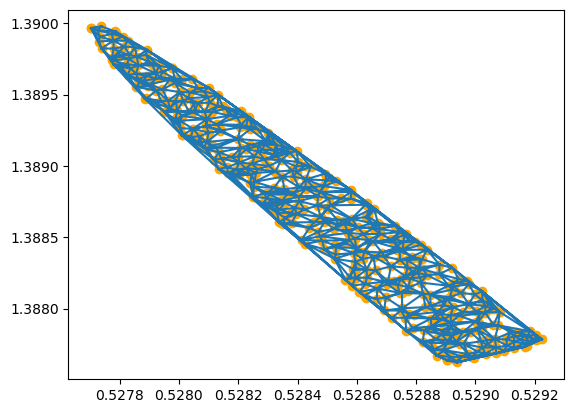

In [241]:
# points = cluster_1_pts
plt.scatter(cluster_1_pts[:,0], cluster_1_pts[:,1], color='orange')
# print(points)
tri = Delaunay(cluster_1_pts)

plt.triplot(cluster_1_pts[:,0], cluster_1_pts[:,1], tri.simplices)
# plt.plot(cluster_1_pts[:,0], cluster_1_pts[:,1], 'o', lw=.1)
# plt.xlim(.41,.415)
# plt.ylim(1.60, 1.65)
plt.show()

In [221]:
plotClusters(try_k)

AttributeError: 'Example' object has no attribute 'getFeatureNames'

In [165]:
threshold_samples

array([[0.52083702, 1.40201721],
       [0.48205158, 1.47407679],
       [0.52949133, 1.38686898],
       ...,
       [0.48483973, 1.46935238],
       [0.53872063, 1.37093634],
       [0.52874827, 1.38798647]])

In [66]:
def rotateMatrix(a):
    return np.array([[np.cos(a), -np.sin(a)], [np.sin(a), np.cos(a)]])

In [284]:
def rotate_samples(samples):
    m, n = np.polyfit(np.array(samples[:,0]), np.array(samples[:,1]), 1)
    # print(max(new_y[:,0]))
    new_y = m * samples[:,0] + n
    # print(max(new_y))
    angle = np.arctan(m)
    # x0, y0 = (min(samples[:,0]) + max(samples[:,0]))/2 , (min(new_y) + max(new_y))/2
    x0, y0 = (min(samples[:,0]) + max(samples[:,0]))/2 , ((m*(min(samples[:,0])+n)) + (m*(max(samples[:,0])+n)))/2
    # print(x0,y0)
    # y0 = (min(new_y[:,0]) + max(new_y[:,1]))/2
    newxy = (samples - [x0, y0]) @ rotateMatrix(angle) + [x0,y0]
    return newxy

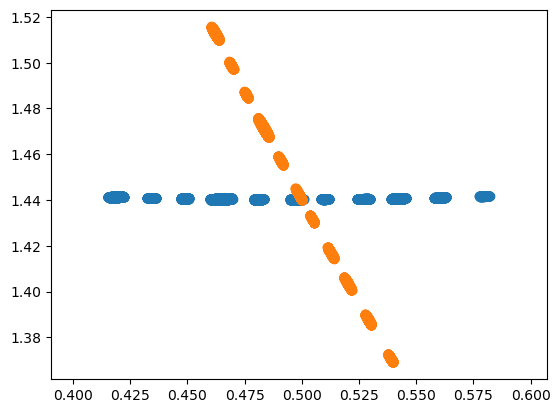

In [286]:
new = rotate_samples(threshold_samples)
plt.xlim(.4,.6)
plt.ylim(1.3, 1.6)
plt.axis('equal')
plt.scatter(new[:,0], new[:,1])
plt.scatter(threshold_samples[:,0], threshold_samples[:,1])


Below is the class to make the concave hull. 

I have no clue really how it works, I took it from this: https://github.com/M-Lin-DM/Concave-Hulls/tree/master 

I'm scared to touch it cause it works rn when I don't touch it.

In [11]:
class ConcaveHull(object):

    def __init__(self, points, k):
        if isinstance(points, np.core.ndarray):
            self.data_set = points
        elif isinstance(points, list):
            self.data_set = np.array(points)
        else:
            raise ValueError('Please provide an [N,2] numpy array or a list of lists.')

        # Clean up duplicates
        self.data_set = np.unique(self.data_set, axis=0)

        # Create the initial index
        self.indices = np.ones(self.data_set.shape[0], dtype=bool)  # bool of a column of all 1's

        self.k = k

    @staticmethod
    def dist_pt_to_group(a, b):  # a is a (n,2) , b is (1,2) arrays
        d = np.sqrt(np.sum(np.square(np.subtract(a, b)), axis=1))
        return d

    @staticmethod
    def get_lowest_latitude_index(points):
        indices = np.argsort(points[:, 1])
        return indices[0]

    @staticmethod
    def norm_array(v):  # normalize row vectors in an array. observations are rows
        norms = np.array(np.sqrt(np.sum(np.square(v), axis=1)), ndmin=2).transpose()
        return np.divide(v, norms)

    @staticmethod
    def norm(v):  # normalize a single vector, is there an existing command?
        norms = np.array(np.sqrt(np.sum(np.square(v))))
        return v / norms

    def get_k_nearest(self, ix, k):
        """
        Calculates the k nearest point indices to the point indexed by ix
        :param ix: Index of the starting point
        :param k: Number of neighbors to consider
        :return: Array of indices into the data set array
        """
        ixs = self.indices
        # base_indices is list of linear indicies that are TRUE, ie part of dataset
        base_indices = np.arange(len(ixs))[ixs]
        distances = self.dist_pt_to_group(self.data_set[ixs, :], self.data_set[ix, :])
        sorted_indices = np.argsort(distances)

        kk = min(k, len(sorted_indices))
        k_nearest = sorted_indices[range(kk)]
        return base_indices[k_nearest]

    def clockwise_angles(self, last, ix, ixs, first):  # last needs to be the index of the previous current point
        if first == 1:
            last_norm = np.array([-1, 0], ndmin=2)
        elif first == 0:
            last_norm = self.norm(np.subtract(self.data_set[last, :], self.data_set[ix,:]))  # normalized vector pointing towards previous point
        ixs_norm = self.norm_array(np.subtract(self.data_set[ixs, :], self.data_set[ix,:]))  # normalized row vectors pointing to set of k nearest neibs
        ang = np.zeros((ixs.shape[0], 1))
        for j in range(ixs.shape[0]):
            theta = np.arccos(np.dot(last_norm, ixs_norm[j, :]))
            # ang[j,0] = theta
            z_comp = np.cross(last_norm, ixs_norm[j, :])
            # ang[j,2] = z
            if z_comp <= 0:
                ang[j, 0] = theta
            elif z_comp > 0:
                ang[j, 0] = 2 * np.pi - theta
        return np.squeeze(ang)

    def recurse_calculate(self):
        """
        Calculates the concave hull using the next value for k while reusing the distances dictionary
        :return: Concave hull
        """
        recurse = ConcaveHull(self.data_set, self.k + 1)
        if recurse.k >= self.data_set.shape[0]:
            print(" max k reached, at k={0}".format(recurse.k))
            return None
        print("k={0}".format(recurse.k))
        return recurse.calculate()

    def calculate(self):
        """
        Calculates the convex hull of the data set as an array of points
        :return: Array of points (N, 2) with the concave hull of the data set
        """
        if self.data_set.shape[0] < 3:
            return None

        if self.data_set.shape[0] == 3:
            return self.data_set

        # Make sure that k neighbors can be found
        kk = min(self.k, self.data_set.shape[0])

        first_point = self.get_lowest_latitude_index(self.data_set)
        current_point = first_point
        # last_point = current_point # not sure if this is necessary since it wont get used until after step 2

        # Note that hull and test_hull are matrices (N, 2)
        hull = np.reshape(np.array(self.data_set[first_point, :]), (1, 2))
        test_hull = hull

        # Remove the first point
        self.indices[first_point] = False

        step = 2
        stop = 2 + kk

        while ((current_point != first_point) or (step == 2)) and len(self.indices[self.indices]) > 0:  # last condition counts number of ones, points in dataset
            if step == stop:
                self.indices[first_point] = True
            # notice how get_k_nearest doesnt take the data set directly as an arg, as it is implicit that it takes self as an imput because we are inside a class:
            knn = self.get_k_nearest(current_point, kk)  # knn = [3,6,2] or [0,2,7] etc indicies into the full dataset (with no points removed)

            if step == 2:
                angles = self.clockwise_angles(1, current_point, knn, 1)
            else:
                # Calculates the headings between first_point and the knn points
                # Returns angles in the same indexing sequence as in knn
                angles = self.clockwise_angles(last_point, current_point, knn, 0)

            # Calculate the candidate indexes (largest angles first). candidates =[0,1,2]  or [2,1,0] etc if kk=3
            candidates = np.argsort(-angles)

            i = 0
            invalid_hull = True

            while invalid_hull and i < len(candidates):
                candidate = candidates[i]

                # Create a test hull to check if there are any self-intersections
                next_point = np.reshape(self.data_set[knn[candidate], :], (1, 2))
                test_hull = np.append(hull, next_point, axis=0)

                line = LineString(test_hull)
                invalid_hull = not line.is_simple  # invalid_hull will remain True for every candidate which creates a line that intersects the hull. as soon as the hull doesnt self intersect, it will become false and the loop will terminate
                i += 1

            if invalid_hull:
                print("invalid hull for all nearest neibs")
                return self.recurse_calculate()

            last_point = current_point  # record last point for clockwise angles
            current_point = knn[candidate] # candidate = 0, 1, or 2 if kk=3
            hull = test_hull

            self.indices[current_point] = False # we remove the newly found current point from the "mask" indicies so that it wont be passed to get_k_nearest (within the implicit input, self)
            step += 1

        poly = Polygon(hull)

        count = 0
        total = self.data_set.shape[0]
        for ix in range(total):
            pt = Point(self.data_set[ix, :])
            if poly.intersects(pt) or pt.within(poly):
                count += 1
            else:
                print("point not in polygon")

        if count == total:
            return hull
        else:
            return self.recurse_calculate()


Now we want to set up our own Concave Hull.

In [12]:
def concave_hull_high_threshold_points(points):
    obj = ConcaveHull(points, 10)
    hull = obj.calculate()
    return hull

Let's double check it actually makes a hull by plotting it and the high threshold points:

In [115]:
vp.pdf(true_a_b)
vp.pdf([.48,1.48])

array([431.33846443])

91
91
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point n

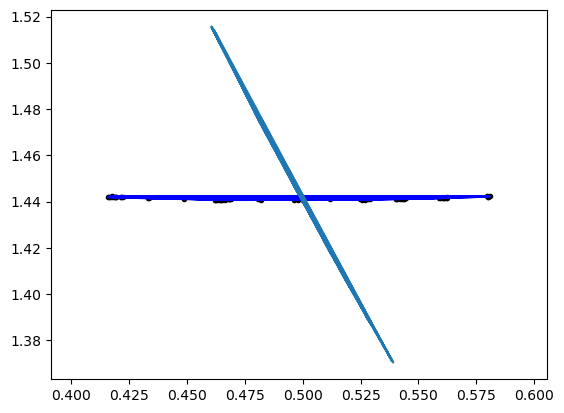

In [311]:
threshold_samples_ = samples_above_threshold(vp, true_a_b, int(3e3))
print(len(threshold_samples_))
rotated_threshold_samples = rotate_samples(threshold_samples_)
print(len(rotated_threshold_samples))
hull_trial = concave_hull_high_threshold_points(rotated_threshold_samples)
plt.plot(rotated_threshold_samples[:,0], rotated_threshold_samples[:,1], 'k.')
plt.plot(hull_trial[:,0], hull_trial[:,1], 'b-')
plt.plot(threshold_samples_[:,0], threshold_samples_[:,1])
plt.axis('equal')
plt.show()

# np.savetxt("hull_dat_try2.csv", hull_trial, delimiter=",")

The function to turn it into a polygon is one line, so we don't particularly need to make a function out of that, but let's graph it just to make sure it looks right. We also use a different polygon function later, so I'll plot that one below as well to make sure that they look the same.

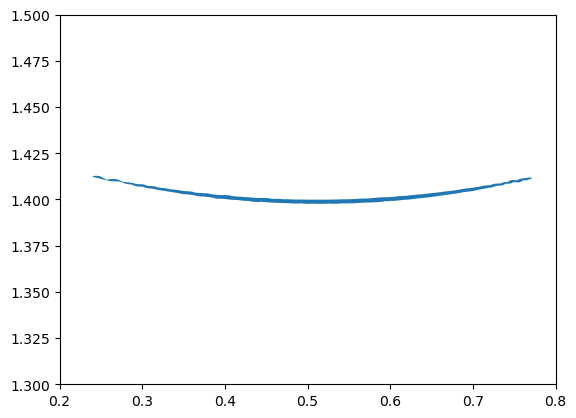

In [119]:
fig = plt.figure()
ax = fig.gca()
ax.set_xlim(.2, .8) # must be set by hand
ax.set_ylim(1.3, 1.5) # must be set by hand
ax.add_patch(patches.Polygon(hull_trial))

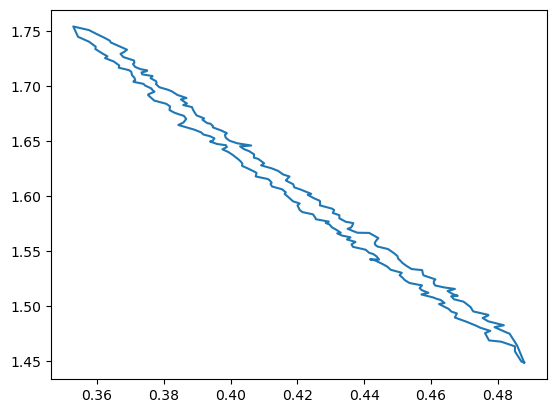

In [17]:
coords = hull_trial
polygon = Polygon(coords)
polygon.area
plt.plot(*polygon.exterior.xy)

- importance sampling (coordinate transform this to make a box out of this)
- aim and then correct off aiming
- voronoi; delaunay
-- smaller triangles where there are more samples helps mitigate the oversampling at high pdfs (instead of taking a uniform distribution)

The best way I found to generate uniformly random points within the weird polygon was to create larger bounds that are just the max and min values out of the hull. Then you check if those points are within the polygon created out of the hull and if they are, add them to a new list and turn them back into floats. That's what generate_random does, and it fills the list up to the number you inputted with it.

In [312]:
def generate_random(number, hull):
    # start = time.process_time()
    points = []
    # polygon = patches.Polygon(hull) # using this as our main polygon makes it run in .1s versus 24s
    # polygon2 = Polygon(hull) # same polygon as above, but allows us to take the area easily later
    
    path = mplPath.Path(hull)

    # print('path', time.process_time() - start)

    minx, miny, maxx, maxy = min(hull[:,0]), min(hull[:,1]), max(hull[:,0]), max(hull[:,1])


    while len(points) < number:
        # pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))

        pnt = (random.uniform(minx, maxx), random.uniform(miny, maxy))
        # pnts = (random.uniform(minx, maxx), random.uniform(miny, maxy),)

        # arry = np.zeros((100,2))
        # arry[:,0] = np.random.uniform(minx, maxx, 100)
        # arry[:,1] = np.random.uniform(miny, maxy, 100)
        

        # start_time = time()
        # path = mpltPath.Path(polygon)
        if path.contains_point(pnt):
            # points.append([pnt.x, pnt.y])
            points.append(pnt)
        # inside2 = path.contains_points(pnt)
        

        # if path.contains_points(arry).all():
        #     print('hit')
        #     points.append(arry[:])

        # if polygon2.contains(pnt):
        #     points.append([pnt.x, pnt.y])
    
    # print('points', time.process_time() - start)
    list_points = np.array(points)

    x, y = hull[:,0], hull[:,1]
    correction = x[-1] * y[0] - y[-1]* x[0]
    main_area = np.dot(x[:-1], y[1:]) - np.dot(y[:-1], x[1:])
    area = 0.5*np.abs(main_area + correction)

    
    # area = polygon2.area
    # area = (maxx - minx) * (maxy - miny) # apparently this is the correct way to take the data
    return list_points, area

In [314]:
random_trial = generate_random(int(3e3), hull_trial)
print(random_trial)

(array([[0.43099897, 1.44153921],
       [0.52667216, 1.44087626],
       [0.49355528, 1.44125597],
       ...,
       [0.4938802 , 1.44097494],
       [0.42329961, 1.44201229],
       [0.50649254, 1.44107696]]), 0.0006933005253541014)


In [20]:
minx, miny, maxx, maxy = min(hull_trial[:,0]), min(hull_trial[:,1]), max(hull_trial[:,0]), max(hull_trial[:,1])
# print(minx, miny, maxx, maxy )
# np.random.uniform(minx, maxx, 50000)
arry = np.zeros((50000,2))
arry[:,0] = np.random.uniform(minx, maxx, 50000)
arry[:,1] = np.random.uniform(miny, maxy, 50000)
print(arry)

[[0.47283301 1.6102407 ]
 [0.3984272  1.47216993]
 [0.3823452  1.55997489]
 ...
 [0.46280995 1.7026989 ]
 [0.35532353 1.72389991]
 [0.35748037 1.72864192]]


In [21]:
path = mplPath.Path(hull_trial)
print(path)
minx, miny, maxx, maxy = min(hull_trial[:,0]), min(hull_trial[:,1]), max(hull_trial[:,0]), max(hull_trial[:,1])
pnt = (random.uniform(minx, maxx), random.uniform(miny, maxy))
print(pnt)
contain = path.contains_point(pnt)
print(contain)

Path(array([[0.48793287, 1.44906676],
       [0.48580794, 1.46454654],
       [0.4835635 , 1.47522134],
       [0.48238531, 1.47668088],
       [0.47905542, 1.48115125],
       [0.48184779, 1.48288735],
       [0.47714298, 1.48647555],
       [0.47548301, 1.48948411],
       [0.47717611, 1.49178132],
       [0.47718294, 1.49231633],
       [0.47270392, 1.49544033],
       [0.47251626, 1.49613528],
       [0.47185245, 1.49951066],
       [0.47057852, 1.50252584],
       [0.46976275, 1.50434506],
       [0.46695626, 1.50644355],
       [0.46606022, 1.5092022 ],
       [0.46800946, 1.50972737],
       [0.46660247, 1.51111641],
       [0.4649928 , 1.51399161],
       [0.46719293, 1.51589629],
       [0.46400385, 1.51724956],
       [0.46126922, 1.51902912],
       [0.46085468, 1.52104589],
       [0.46090062, 1.5230562 ],
       [0.46133438, 1.52459223],
       [0.45783031, 1.52816128],
       [0.45761446, 1.52930353],
       [0.45737447, 1.53296799],
       [0.4541755 , 1.53400126],
     

We can check to make sure it's working below.

In [22]:
hull_trial

array([[0.48793287, 1.44906676],
       [0.48580794, 1.46454654],
       [0.4835635 , 1.47522134],
       [0.48238531, 1.47668088],
       [0.47905542, 1.48115125],
       [0.48184779, 1.48288735],
       [0.47714298, 1.48647555],
       [0.47548301, 1.48948411],
       [0.47717611, 1.49178132],
       [0.47718294, 1.49231633],
       [0.47270392, 1.49544033],
       [0.47251626, 1.49613528],
       [0.47185245, 1.49951066],
       [0.47057852, 1.50252584],
       [0.46976275, 1.50434506],
       [0.46695626, 1.50644355],
       [0.46606022, 1.5092022 ],
       [0.46800946, 1.50972737],
       [0.46660247, 1.51111641],
       [0.4649928 , 1.51399161],
       [0.46719293, 1.51589629],
       [0.46400385, 1.51724956],
       [0.46126922, 1.51902912],
       [0.46085468, 1.52104589],
       [0.46090062, 1.5230562 ],
       [0.46133438, 1.52459223],
       [0.45783031, 1.52816128],
       [0.45761446, 1.52930353],
       [0.45737447, 1.53296799],
       [0.4541755 , 1.53400126],
       [0.

In [23]:
def polygon_area(x,y):
    correction = x[-1] * y[0] - y[-1]* x[0]
    main_area = np.dot(x[:-1], y[1:]) - np.dot(y[:-1], x[1:])
    return 0.5*np.abs(main_area + correction)

In [24]:
polygon_area(hull_trial[:,0], hull_trial[:,1])

0.0019239541651501213

In [25]:
random_trial[0]

array([[0.46967989, 1.49856894],
       [0.43349678, 1.57653481],
       [0.40760488, 1.63041801],
       ...,
       [0.42662099, 1.58369797],
       [0.48492004, 1.46458372],
       [0.45935142, 1.51704054]])

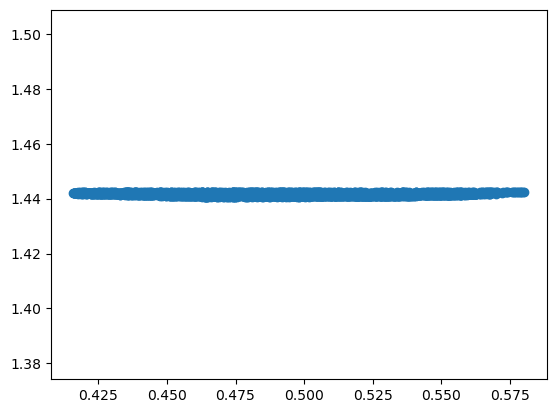

In [315]:
plt.axis('equal')
plt.scatter(random_trial[0][:,0], random_trial[0][:,1])

Now we take the pdf of those random points, average the value, and multiply that by the area we found in generate_random. Later will be a function that puts everything together, but this is a simple one for now, just to make sure it works

In [339]:
def create_CI(vp, random_pulls, samples):
    m, n = np.polyfit(np.array(samples[:,0]), np.array(samples[:,1]), 1)
    # print(max(new_y[:,0]))
    new_y = m * samples[:,0] + n
    # print(max(new_y))
    angle = np.arctan(m)
    x0, y0 = (min(samples[:,0]) + max(samples[:,0]))/2 , (min(new_y) + max(new_y))/2
    points, area = random_pulls[0], random_pulls[1]
    
    newxy = (points - [x0, y0]) @ rotateMatrix(-angle) + [x0,y0]
    # plt.axis('equal')
    # # plt.xlim(.4,.6)
    # # plt.ylim(1.3, 1.6)
    # # plt.axis('equal')
    # plt.scatter(newxy[:,0], newxy[:,1])
    # plt.scatter(samples[:,0],samples[:,1], color='orange')
    # plt.scatter(points[:,0], points[:,1])




    pdfs = vp.pdf(newxy)
    integral = np.sum(pdfs)/len(pdfs) * area # same as average of pdfs multiplied by the area
    # return integral
    return [newxy, samples, points]

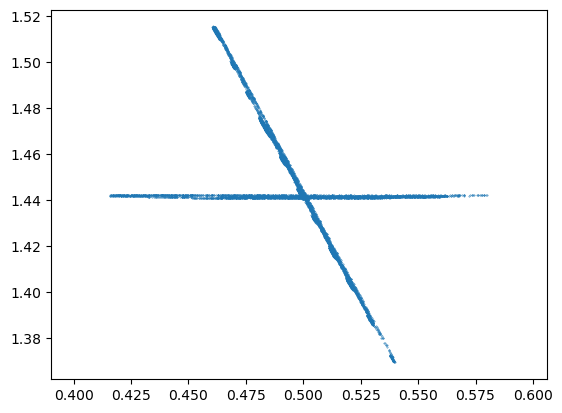

In [340]:
what = create_CI(vp, random_trial, threshold_samples)

what2 = np.concatenate(what)
plt.xlim(.4,.6)
plt.ylim(1.3, 1.6)
plt.axis('equal')
plt.scatter(what2[:,0], what2[:,1], s=.1)


In [320]:
create_CI(vp, random_trial, threshold_samples) # different now

0.4427721433001389

Now we want to put it all together, to have it just return the CI using the threshold without having to run tons of functions.

In [334]:
def create_CI_using_threshold(vp, true_value, n_samples, number):
    start = time.process_time()
    samples_used = samples_above_threshold(vp, true_value, n_samples)
    # print(type(samples_used))
    # print("samples_used", time.process_time() - start)
    rotated_samples = rotate_samples(samples_used)
    # start = time.process_time()
    # print("rotated samples", time.process_time()- start)
    hull =  concave_hull_high_threshold_points(rotated_samples)
    # start = time.process_time()
    # print('hull',time.process_time() - start)
    uniform_rand_pnts_in_poly = generate_random(number, hull)
    # start = time.process_time()
    # print('uniform_rand_pnts_in_poly',time.process_time() - start)
    CI = create_CI(vp, uniform_rand_pnts_in_poly, samples_used)
    # start = time.process_time()
    # print('CI',time.process_time() - start)
    return CI

In [336]:
create_CI_using_threshold(vp, true_a_b, int(2e3), int(5e5))

samples_used 0.08952300000237301
rotated samples 0.09049600000071223
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point n

3.5724732818683815

In [ ]:
create_CI_using_threshold(vp, [0.0,0.0], int(5e5), int(5e5))

In [ ]:
class create_CI_delaunay():
    def __init__(self, vp, true_value, n_samples, dimensions):
        self.vp = vp
        self.true_value = true_value
        self.n_samples = int(n_samples)
        self.dimensionality = int(dimensions)

    def samples_above_threshold(self):
        if len(true_value) > 1: # find the pdf of our true value
            threshold = min(vp.pdf(np.array(true_value)))
        else:
            threshold = vp.pdf(true_value)
        vp = self.vp
        true_value = self.true_value
        n_samples = self.n_samples

        Xs, _ = vp.sample(n_samples) # get samples out of the distribution
        pdfs = vp.pdf(Xs) # find the pdf of each of those samples

        high_threshold_samples = []
        
        for i in range(len(pdfs)):
            if pdfs[i] >= threshold_edited and len(high_threshold_samples) <= n_samples:
                high_threshold_samples.append(Xs[i])
                if len(high_threshold_samples) == n_samples:
                    break

        return np.array(high_threshold_samples)


    def minkowskiDist(v1, v2):
        #Assumes v1 and v2 are equal length arrays of numbers
        dist = 0
        for i in range(len(v1)):
            dist += abs(v1[i] - v2[i])**2
        return dist**(1/2)
    
    class Example(object):
    
        def __init__(self, features):
            #Assumes features is an array of floats
            self.features = features

        def dimensionality(self):
            return len(self.features)

        def getFeatures(self):
            return self.features[:]

        def distance(self, other):
            return minkowskiDist(self.features, other.getFeatures())
    
    

        
    